# 2.1 Image processing tools

Image processing encompasses a number of techniques to improve the overall quality of an image (image smoothing, enhancement, etc.). Before going into those techniques in depth, it is useful to understand some basic concepts:

- Image histograms
- Brightness and contrast
- Binarization
- Look up tables

Next sections introduce those concepts in the context of a real problem. 

## Problem context - Number-plate recognition

<img src="./images/access_system.png" width="400">


Recently, the University of Málaga (UMA) is having trouble with private parking access. Someone has hacked their access system, so cars without previous authorization are parking there.

UMA asked computer vision students for help to implement some more secure methods that have to be included in a new security system.

They provided some images of unauthorized plates to ease the software development: `car_plate_1.jpg`, `car_plate_2.jpg` and `car_plate_3.jpg`.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interactive, fixed, widgets
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

images_path = './images/'

## 2.1.1 Image histograms

And there we go! We are excited with the idea of developing a software to help UMA. For that, they provided us with a list of concepts and techniques that we have to master in order to design a successful plate recognition system. 

The first one is such of **histogram**:

- A representation of the frequency of each color intensity appearing in the image.
- It is built by iterating over all the pixels in the image while counting the occurrence of each color. *Note that a RGB image has 3 histograms, one per channel.* 
- It provides statistical information of the intensity distribution, like the image brightness or contrast. 

The concepts of **brightness** and **contrast** are specially relevant for image processing:
- *brightness*: average intensity of image pixels, so dark images have a low brightness, while lighter ones have a high brightness. 
- *contrast*: square distance of the intensities from the average, that is, a measure of the quality of the image given its usage of all the possible color intensities in the histogram. 

Typically, a high quality image have a medium brightness and a high contrast. 

The following code illustrates these first concepts with a few examples!

*Interesting functions:* 
- [`cv2.imread()`](https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/) *function for reading images in OpenCV.*
- [`plt.subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) *this method from matplotlib creates a grid of subfigures with a given number of rows and columns.* 
- [`plt.hist()`](https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.hist.html) *function that computes and draws the histogram of an array.  [`numpy.ravel()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html) is a good helper here, since it converts a n-dimensional array into a flattened 1D array.* 
- [`plt.imshow()`](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.imshow.html) *matplotlib function for displaying images. If the image is grayscale you should use the parameter `cmap='gray'`.*

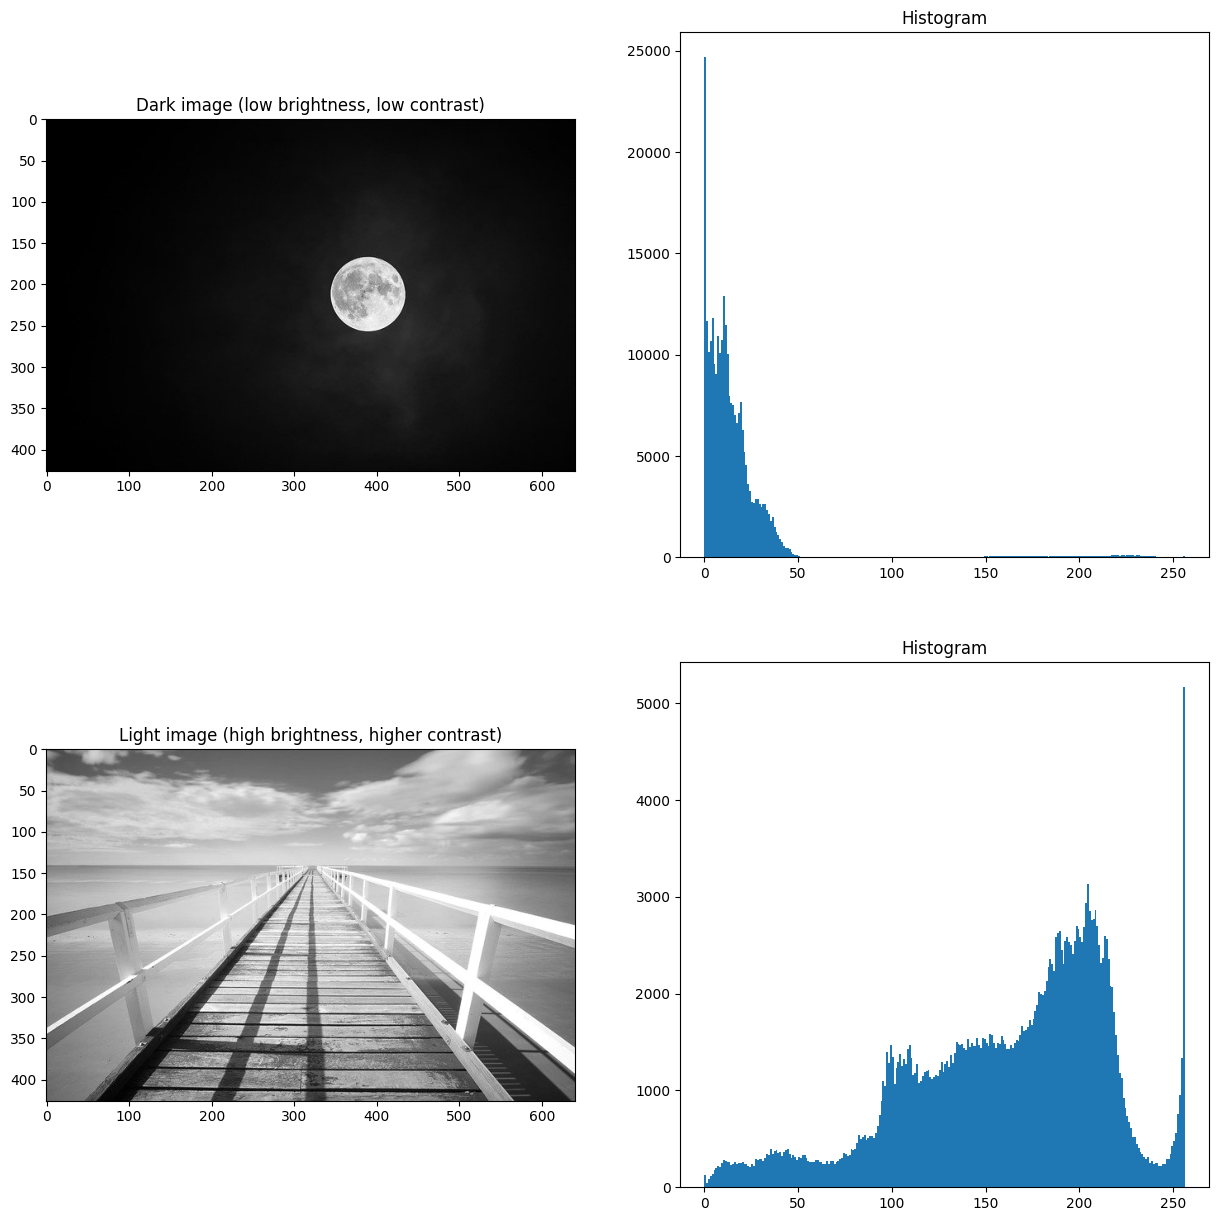

In [2]:
# Read dark image and show it
image = cv2.imread(images_path + 'landscape_1.jpg',cv2.IMREAD_GRAYSCALE)
plt.subplot(2,2,1)
plt.title("Dark image (low brightness, low contrast)")
# plt.xticks([]), plt.yticks([])  # this option hides tick values on X and Y axis
plt.imshow(image, cmap='gray')

# Now, show its histogram
plt.subplot(2,2,2)
plt.title("Histogram")
plt.hist(image.ravel(),256,[0,256]) # ravel() returns a 1-D array, containing the elements of image

# Read light image and show it
image = cv2.imread(images_path + 'landscape_2.jpg',cv2.IMREAD_GRAYSCALE)
plt.subplot(2,2,3)
plt.title("Light image (high brightness, higher contrast)")
plt.imshow(image, cmap='gray')

# Now, its histogram
plt.subplot(2,2,4)
plt.title("Histogram")
plt.hist(image.ravel(),256,[0,256]) # ravel() returns a 1-D array, containing the elements of image
plt.show() 

## 2.1.2 Binarization 

One of the utilities of histograms is the fit of thresholds for **binarization**. Binarization consists of assigning the "0" or black value to the pixels having an intensity value under a given threshold (`th`), and "1" or white value to those having an intensity over it. Formally:

$$
binarized(i,j)=\left\{\begin{matrix}
0 & \text{if } intensity(i,j) < th\\ 
1 & \text{otherwise}
\end{matrix}\right. \ \ \ \forall i \in [0 \dots n\_rows-1], \forall j \in [0 \dots n\_cols-1]
$$ 

In our context, binarization can be a great tool for separating characters appearing on the plate (with a dark color) from the rest of the plate (with a lighter one). This will remove unnecessary information within the image. So let's implement it!

### **<span style="color:green"><b><i>ASSIGNMENT 1: Cropping an image</i></b></span>**

Read the image `car_plate_1.jpg` and crop it to a rectangle (approximately) containing the plate.

*Hint: to crop an image you can use numpy array slicing.* 

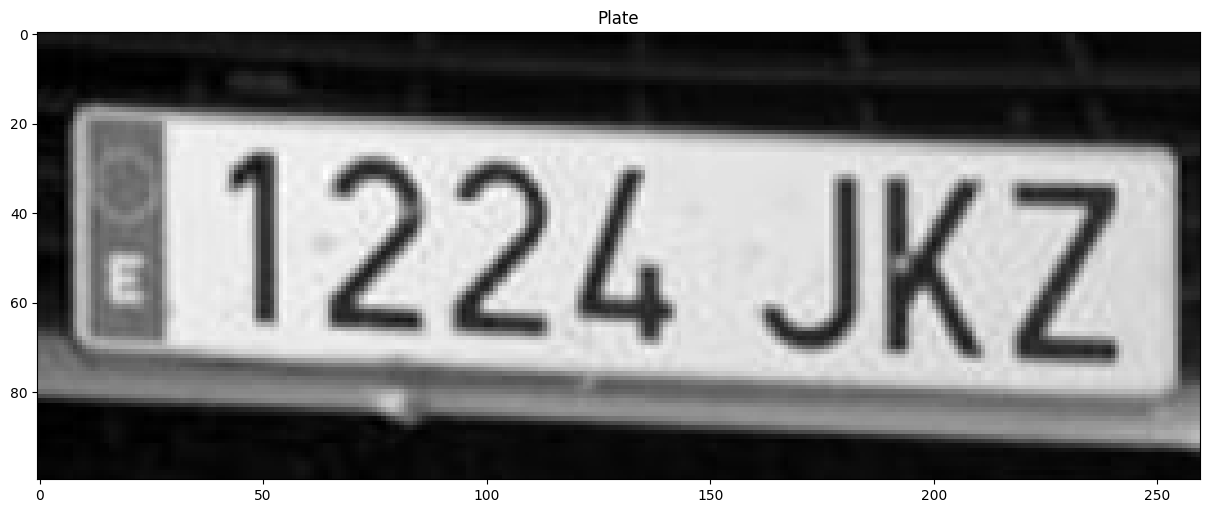

In [3]:
# ** ASSIGNMENT 1 **
# Load the image, crop it around the car plate and show it
# Write your code here!

image = cv2.imread(images_path + 'car_plate_1.jpg',cv2.IMREAD_GRAYSCALE) # Load the image
image_cropped = image[300:400, 200:460] # crop it
plt.imshow(image_cropped, cmap='gray') # show it!
plt.title('Plate')
plt.show()

Now, we are going to use the first concept we learned, **histograms**, to see if the image is easily binarizable. To fulfill this condition, the intensity of the pixels in the image must be roughly grouped around two different values. 

### **<span style="color:green"><b><i>ASSIGNMENT 2: Showing a histogram</i></b></span>**

Show the histogram of `image_cropped`.

*Tip: [plot histogram using matplotlib](https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.pyplot.hist.html), bins and range parameters are very important! Also recall the `ravel()` funciton*

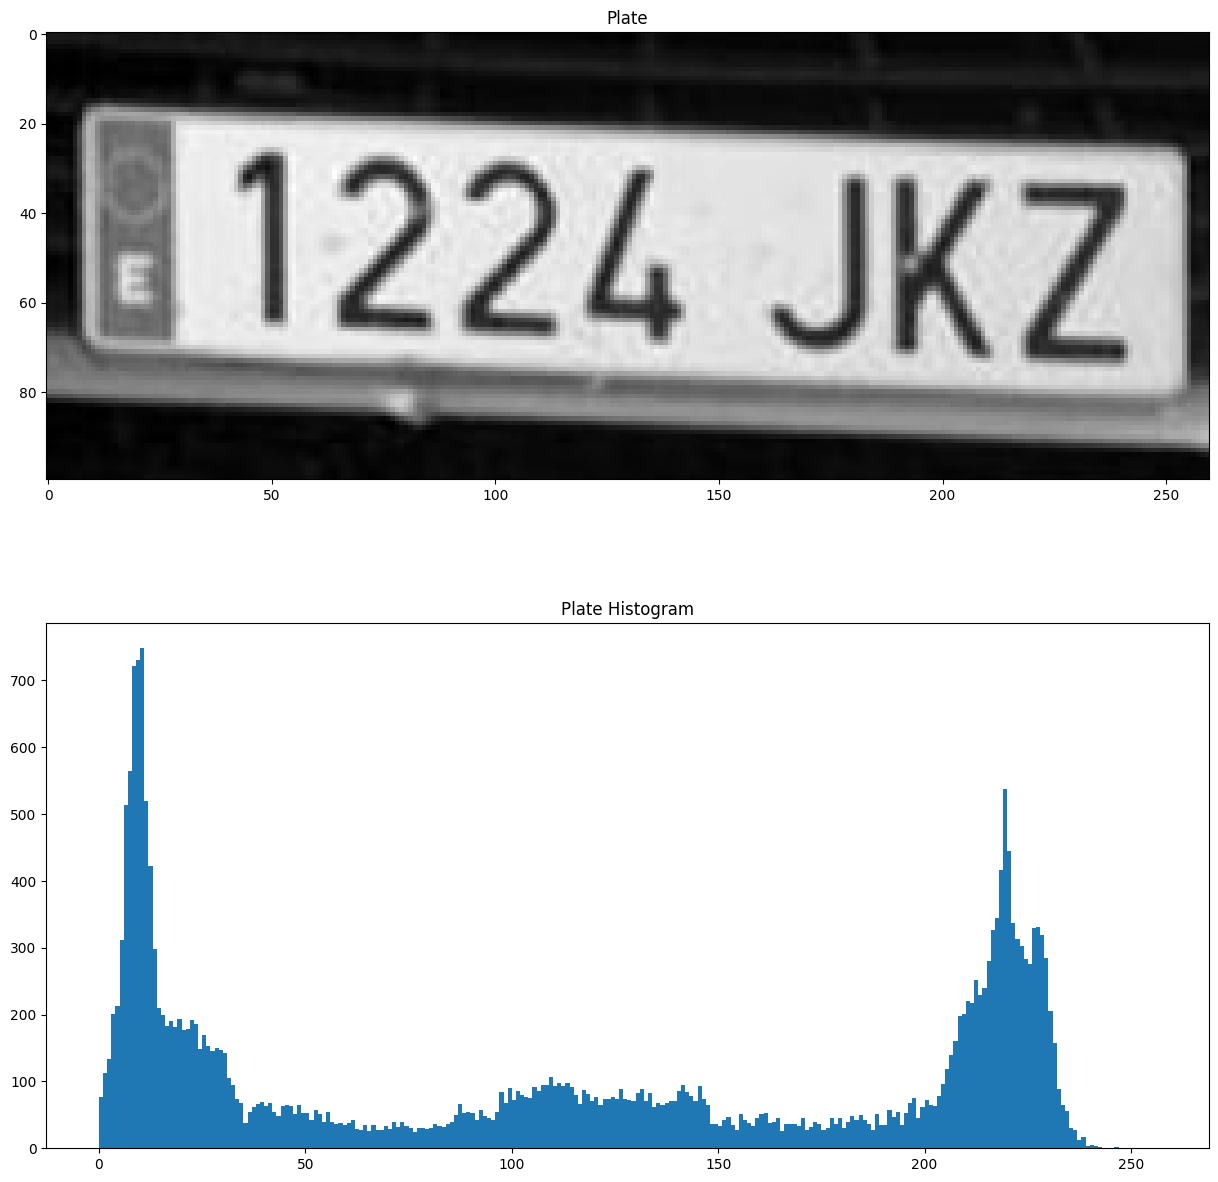

In [4]:
# ** ASSIGNMENT 2 **
# Compute the image histogram and show it
# Write your code here!

# Compute the histogram and show it
plt.subplot(2,1,1)
plt.imshow(image_cropped, cmap='gray')
plt.title('Plate')
plt.subplot(2,1,2)

plt.hist(image_cropped.ravel(), 256, [0,256])

plt.title('Plate Histogram')
plt.show()

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

**Answer the following questions** about the obtained results:

- According to your (growing) expertise, could we correctly binarize this image? 

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Idea: Hay dos zonas claramente diferenciadas de negros (0-40) y blancos (200-240), mientras que los valores intermedios son menos significativos. Por lo tanto sería correcto y efectivo aplicar una binarización de la imagen</i></p>

- Which threshold should we use?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Podríamos usar la mediana o el valor medio, o incluso directamente 128. Para esta imagen, veremos más adelante, los valores entre 110 y 150 dan buenos resultados.</i></p>

### **<span style="color:green"><b><i>ASSIGNMENT 3: Binarizing an image. Exiting, isn't it?</i></b></span>**

Now that we have some cues about how to binarize an image, let's take a look through [OpenCV documentation](https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html) to develop it. 

Implement a function that:
- takes a gray image and a threshold as inputs, 
- binarizes the image,
- and displays it!

*Hint: Notice that some OpenCV functions returns in first place a variable called **ret**, which content depends on the function itself.*

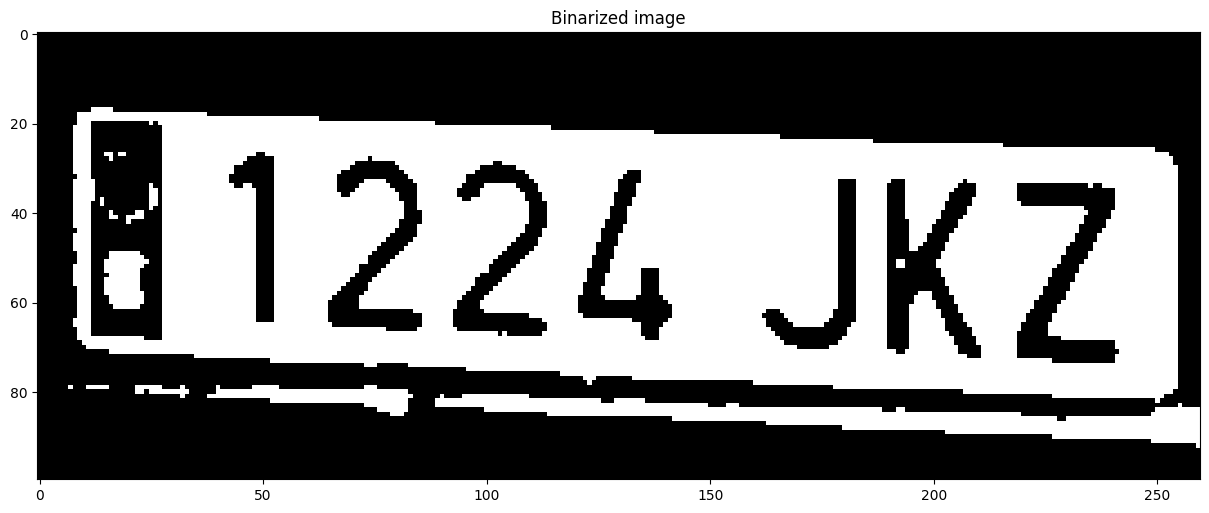

In [5]:
# ** ASSIGNMENT 3 **
# Implement a function that binarizes an image and displays it
def binarize(image,threshold):
    """ Binarizes an input image and returns it.   
    
        Args:
            image: Input image to be binarized
            threshold: Pixels with intensity values under this parameters
                    are set to 0 (black), and those over it to 255 (white).  
                    
        Returns: 
            image_binarized: Binarized image
    """   
    #ret
    image_binarized = image > threshold
    plt.imshow(image_binarized, cmap='gray')
    plt.title('Binarized image')
    plt.show()   
    return image_binarized
threshold = 128
image_binarized = binarize(image_cropped, threshold)


#### Extra! interacting with code

Jupyter has some interesting methods that allow interaction with our code, and we are going to leverage them throughout the course. Concretely, we will use the [interaction function](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html). 

To play a bit with it, move the slider below to change the threshold value when calling the `binarize()` function. 

In [6]:
# Interact with the threshold value
interactive(binarize, image=fixed(image_cropped), threshold=(0, 255, 10))

interactive(children=(IntSlider(value=120, description='threshold', max=255, step=10), Output()), _dom_classes…

## 2.1.3 Look-up Tables (LUTs) 

Another basic, widely used technique for image processing is such of **Look-up Tables (LUTs)**. A LUT is a table to look up the output intensity for each input one. That is, it defines a mapping between input intensity values and output ones.

Note that if working with color (e.g. RGB) images, a LUT has to be defined for each color channel. 

LUTs are extremely useful for modifying the brightness and contrast of images, that is, for adapting their histograms according to our needs. Some examples about the possibilities that LUTs offer are shown below (the x-axes represent input intensity values, while y-axes represent output ones):

<img src="./images/bright_contrast.png" width="1000"/> 

For example, the figure below shows the result of applying a LUT where the pixels with intensities from 0 to 50 are assigned to 0 (black), and those from 200 to 255 are assigned to 255 (white). Pixels with values in between are assigned to values from 1 to 254. The histogram of the resultant image is also shown:

<img src="./images/result_lut.png" width="500"/> 

Regarding our plate recognition problem, by doing this we remove noisy intensity values around black and white, obtaining a more *clean* image (see the resultant histogram). And, of course, we want to try it!

### **<span style="color:green"><b><i>ASSIGNMENT 4a: Things get serious, implementing a LUT!</i></b></span>**

Implement the `lut_chart()` function to:
- take a gray image and a look-up table (256-length array), 
- display a chart showing differences between the initial image and the resultant one after applying the LUT. *Tip: [how to create subplots in Python](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplot.html)*

*Interesting functions:* 
- [cv2.LUT()](https://docs.opencv.org/master/d2/de8/group__core__array.html#gab55b8d062b7f5587720ede032d34156f): *function that  performs a look-up table transform of an array of arbitrary dimensions.*

In [7]:
# ** ASSIGNMENT 4a **
# Implement a function that takes a gray image and applies a LUT to it. This must show a 2x2 plot with
# -- input image
# -- resultant image
# -- employed LUT
# -- histogram of the resultant image
def lut_chart(image, lut):
    """ Applies a LUT to an image and shows the result. 
    
        Args:
            image: Input image to be modified.
            lut: a 256 elements array representing a LUT, where 
                indices index input values, and their content the
                output ones.        
    """   
    # Apply LUT
    im_lut = cv2.LUT(image, lut)
    
    
    # Show the initial image
    plt.figure(1)
    plt.subplot(2, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original image')
    
    # Show the resultant one
    plt.subplot(2, 2, 2)
    plt.imshow(im_lut, cmap='gray')
    plt.title('LUT applied')
    
    # Plot the used LUT
    plt.subplot(2,2,3)
    plt.title('LUT')
    plt.plot(np.arange(0,256), lut) # Hint: np.arange() can be useful as first argument to this function

    # And finally, the resultant histogram
    plt.subplot(2, 2, 4)
    plt.hist(im_lut.ravel(), 256, [0, 256])
    plt.title('Histogram')
    plt.show()


### **<span style="color:green"><b><i>ASSIGNMENT 4b: Applying our amazing function</i></b></span>**

Finally, let's try our `lut_chart()` function with different look-up tables. Try to play with bright and contrast in order to get an enhanced image. For that:

1. Create a look-up table.
2. Call our function with it as second argument.

You can repeat the previous steps playing with different look-up tables and showing the results using *subplots*.

*Hint: An easy way to create a LUT could be:*
1. Create an *identity LUT* with numbers from 0 up to 255 with [`numpy.arange()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.arange.html) (this function returns evenly spaced values within a given interval). If you use this directly as LUT, the pixels in the output will have the same intensity value as in the input. Try it!
2. Modify such LUT using [`numpy.clip()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.clip.html). For that you could call it as `lut = np.clip((lut-a)*b,0,255)`.

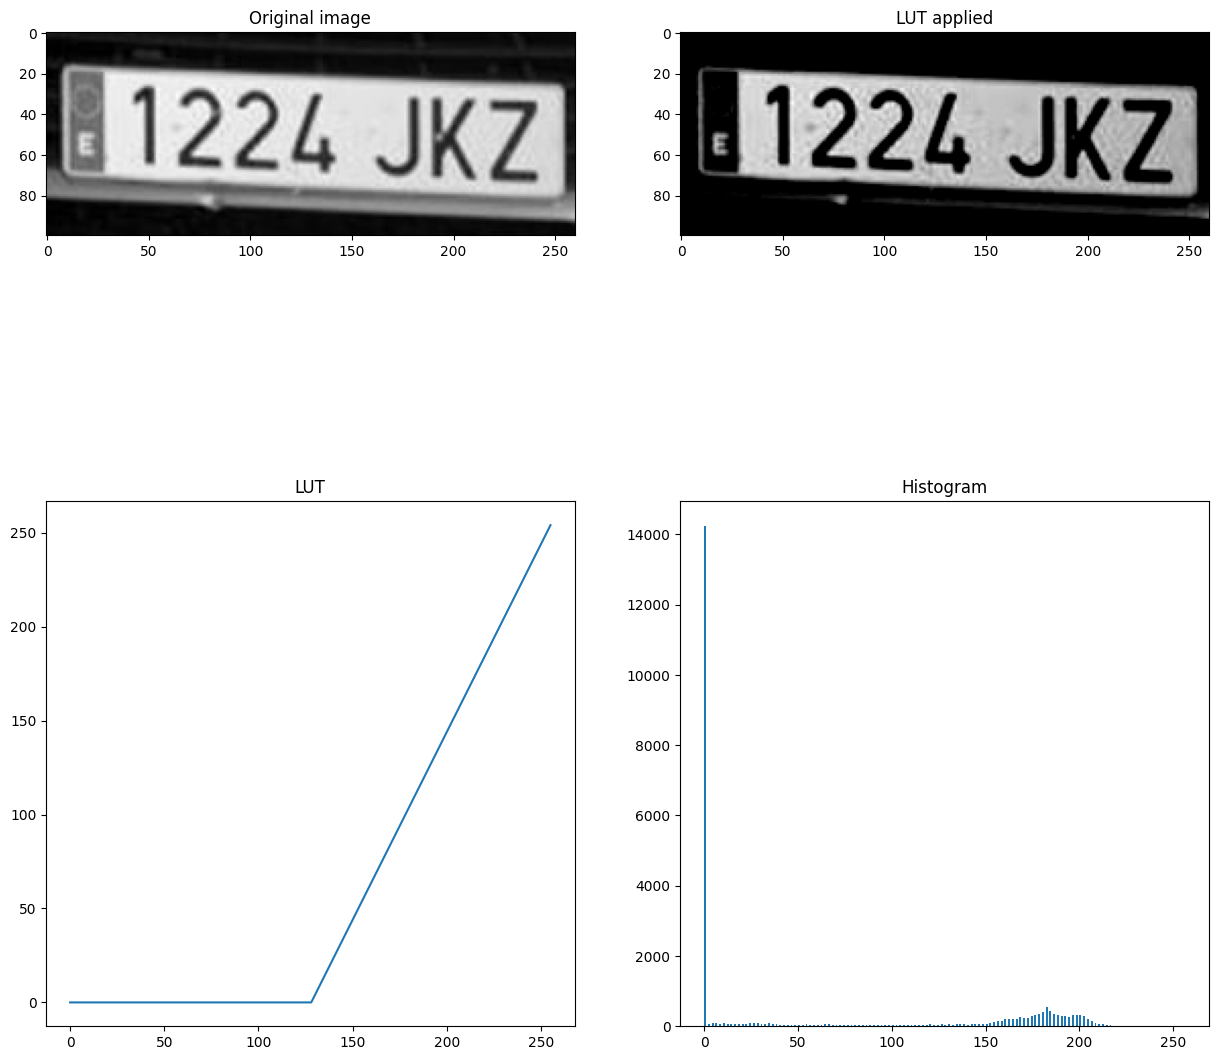

In [8]:
# ASSIGNMENT 4b
# Create the LUT array (have a look to numpy.arange and numpy.clip functions)
lut = np.arange(0, 256, 1, dtype=int)
a = 128
b = 2
lut = np.clip((lut-a)*b, 0, 255)
# Execute our function on the cropped car plate image
lut_chart(image_cropped,lut)

## 2.1.4 Convolutions

A 2D convolution, represented by the $\oplus$ symbol, is a fundamental tool in numerous image processing techniques (e.g. image smoothing, edge detection, etc.). Concretely, this mathematical operation is useful when implementing operators whose output pixel values are linear combinations of input ones.

There are two principal actors in a convolution: **the image** and **the kernel**. Both are 2D matrices, but usually the **kernel has a significant lower size** compared with the image. Let's define them as:

- **Image ($I$)**: The image in which some image processing technique is needed.  

<img src="./images/lena.jpeg" width="200">


- **Kernel ($K$)**: A small 2D matrix that defines the linear operation that is going to be applied over the image.

<table>
	<tbody>
		<tr>
			<td style="border: 1px solid;">1/9</td>
			<td style="border: 1px solid;">1/9</td>
			<td style="border: 1px solid;">1/9</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1/9</td>
			<td style="border: 1px solid;">1/9</td>
			<td style="border: 1px solid;">1/9</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1/9</td>
			<td style="border: 1px solid;">1/9</td>
			<td style="border: 1px solid;">1/9</td>
		</tr>
	</tbody>
</table> $\\[5pt]$

Once we have defined the input image and the kernel, the convolution operation for a certain pixel with coordinates $r$ and $c$ results:$\\[5pt]$

$$O(r,c) = \sum_{i=-w}^w \ \sum_{j=-w}^w \ I(r+i, c+j) * K(-i, -j)$$

where:  
- $O$ is the output image.  
- $w$ is the kernel aperture size (for example, the kernel shown above would have an aperture of $w=1$).

But, what does this equation actually does?

> Convolution is the process of adding each element of the input image with its local neighbors, weighted by the kernel. For example, if we have two three-by-three matrices, one of them a kernel, and the other a piece of the image, convolution is the process of **flipping both the rows and columns of the kernel and then multiplying locationally similar entries and summing**

For example, the pixel value in the [2,2] position on the resulting image would be a weighted combination of all the entries of the image matrix, with weights given by the kernel. $\\[5pt]$

$$\left(\begin{bmatrix} 1 & 2 & 3\\ 4 & \color{red}5 & 6 \\ 7 & 8 & 9\end{bmatrix}  \oplus \begin{bmatrix} a & b & c\\ d & e & f \\ g & h & i\end{bmatrix} \right)\color{red}{[2,2]} = (1*i) + (2*h) + (3*g) + (4*f) + (5*e) + (6*d) + (7*c) + (8*b) + (9*a)$$

As said above, if we flip the kernel across both axes, the formula of the convolution turns into an element-wise matrix multiplication:$\\[5pt]$

$$\left(\begin{bmatrix} 1 & 2 & 3\\ 4 & \color{red}5 & 6 \\ 7 & 8 & 9\end{bmatrix}  \oplus \begin{bmatrix} a & b & c\\ d & e & f \\ g & h & i\end{bmatrix} \right)\color{red}{[2,2]} = \left(\begin{bmatrix} 1 & 2 & 3\\ 4 & 5 & 6 \\ 7 & 8 & 9\end{bmatrix} .* \begin{bmatrix} i & h & g\\ f & e & d \\ c & b & a\end{bmatrix} \right) = (1*i) + (2*h) + (3*g) + (4*f) + (5*e) + \ldots $$

When convolution is applied, it usually indexes out of bounds in the image, e.g.:$\\[5pt]$

$$\left(\begin{bmatrix} \color{red}1 & 2 & 3\\ 4 & 5 & 6 \\ 7 & 8 & 9\end{bmatrix}  \oplus \begin{bmatrix} a & b & c\\ d & e & f \\ g & h & i\end{bmatrix} \right)\color{red}{[1,1]} = (\color{red}?*i) + (\color{red}?*h) + (\color{red}?*g) + (\color{red}?*f) + (1*e) + (2*d) + (\color{red}?*c) + (4*b) + (5*a)$$

There are some **padding** options to deal with this problem:

- Fill out of bound values with a constant value (**usually 0** or **values in the border** of the image),$\\[2pt]$
- reflecting image values (e.g. $I[0,0] = I[1,1]$)
- $\ldots$

Regarding our dear OpenCV library, it helps us by defining the 2D-convolution [cv2.filter2D()](https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04) method. Its main inputs are:

- **src**: source image
- **ddepth**: data type of output image (`cv2.CV_8U` for 8-bits unsigned integer, `cv2.CV_16S` for 16-bits signed integer, $\ldots$). **It depends on the kernel** you use. Note that there are kernels that can return negative values in the convolution output.
- **kernel**: convolution kernel.
- **borderType**: padding options ([border types](https://docs.opencv.org/master/d2/de8/group__core__array.html#ga209f2f4869e304c82d07739337eae7c5)).

Let's try convolution in a example!  

### **<span style="color:green"><b><i>ASSIGNMENT 5</i></b></span>**

Apply a convolution to the grayscale image `lena.jpeg` using a $3\times3$ kernel with a constant value of $1/9$.

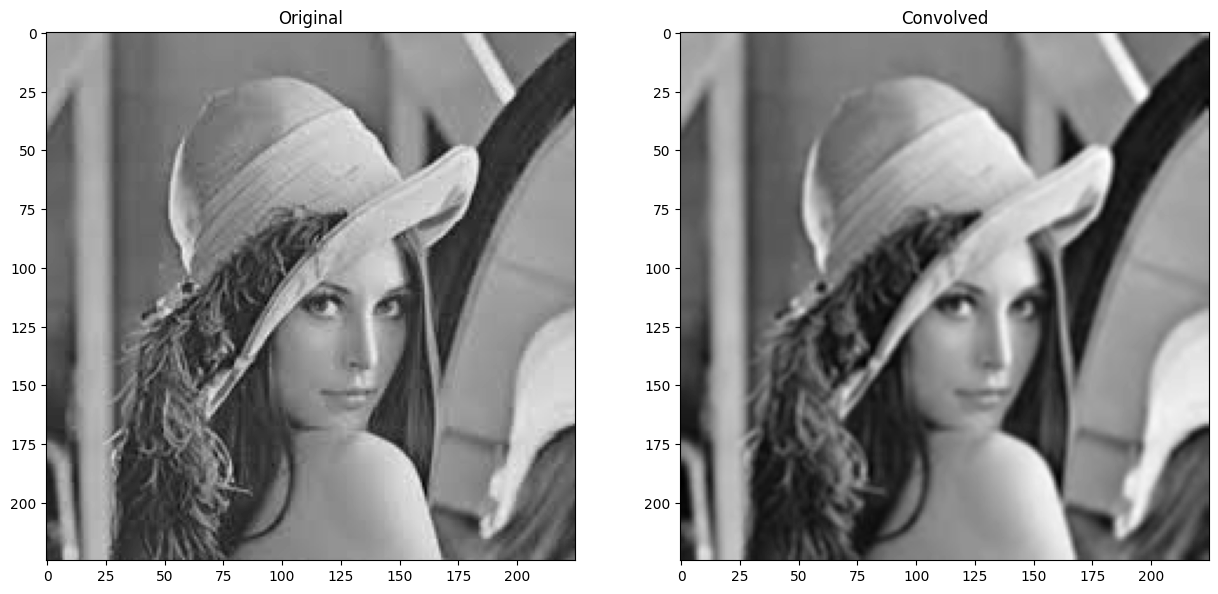

In [9]:
# ASSIGNMENT 5
# Read the image
image = cv2.imread(images_path + 'lena.jpeg',cv2.IMREAD_GRAYSCALE)

# Define the kernel
kernel = np.matrix([[1/9 for i in range(0,3)] for j in range(0,3)])

# Apply convolution (note that convolution cannot return negative values using this kernel)
im_conv = cv2.filter2D(image, cv2.CV_8U, kernel, cv2.BORDER_CONSTANT)

# Show original image
plt.subplot(121)
plt.title('Original')
plt.imshow(image, cmap='gray')

# Show convolved image
plt.subplot(122)
plt.title('Convolved')
plt.imshow(im_conv, cmap='gray')
plt.show()

### <font color="blue"><b><i>Thinking about it (2)</i></b></font>

**Answer the following questions** about convolution:

- What is the difference between the original image and the convolved one?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>La imagen resultante es más borrosa, ya que hemos aplicado la media entre los píxeles vecinos para cada píxel.</i></p>

- Can you guess which IP technique is such kernel implementing?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Suavizado (Smoothing)</i></p>

Additionally, you can use [this demo](https://setosa.io/ev/image-kernels/) to understand the convolution operator for image processing in a visual way. Anyway, **don't worry if you don't fully understand it**, convolution is a complex operation that have multiple applications and will be understood progressively while doing practical exercises. Exciting, isn't it?

## Conclusion

Brilliant! With this notebook we have:
- Learned basic concepts within image processing like histograms, brightness, contrast, binarization and Look-up Tables. 
- Played a bit with them in the context of a plate recognition system, observing their utility for improving the quality of an image according to our needs. 
- Understood how convolution works. 